In [1]:
# try the imports
import os
import torch
import math
import numpy as np
import pandas as pd
import sys
import random
import matplotlib.pyplot as plt
import skimage
from descarteslabs import Storage, Auth
%pip install torchsummary
from torchsummary import summary
sys.path.append("../")
import constants
from tqdm.notebook import tqdm
sys.path.append('../UI_Labeling')
import config
from torch.utils.data import Dataset, DataLoader

import io
from PIL import Image
from torchvision import models, transforms
from torch.autograd import Variable
from torch.nn import functional as F
!{sys.executable} -m pip install opencv-contrib-python
import cv2
import json
import torchvision.transforms as T
from torchvision import transforms

from shapely.wkt import loads
import geopandas
from descarteslabs.scenes import DLTile
import geojson
import descarteslabs.workflows as wf
from ipyleaflet import GeoJSON
import json
from descarteslabs.scenes import AOI
from descarteslabs.workflows.models.exceptions import JobTimeoutError
import torch
from scipy import signal
from scipy import ndimage

Looking in indexes: https://pypi.org/simple, https://packagecloud.io/github/git-lfs/pypi/simple
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.org/simple, https://packagecloud.io/github/git-lfs/pypi/simple


/opt/conda/lib/python3.7/site-packages/descarteslabs/_dl_modules/common/workflows/arrow_serialization/context.py:57: FutureWarning: 'pyarrow.SerializationContext' is deprecated and will be removed in a future version. Use pickle or the pyarrow IPC functionality instead.
  serialization_context = pa.SerializationContext()
/opt/conda/lib/python3.7/site-packages/descarteslabs/_dl_modules/common/workflows/arrow_serialization/context.py:58: FutureWarning: 'pyarrow.register_default_serialization_handlers' is deprecated as of 2.0.0 and will be removed in a future version. Use pickle or the pyarrow IPC functionality instead.
  pa.register_default_serialization_handlers(serialization_context)


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
class Combo_BI_Dataset(Dataset):
    """
    Dataset for country/ies DL Sentinel2 10-channel imagery.
    """
    def __init__(self, DS_Name, balance=False, limit=0, mode="full",transform=None):
        super(Combo_BI_Dataset, self).__init__()
        self.df=pd.DataFrame()
        self.upsampled=True
        self.transform=transform
        
        def add_dataset(dataset_name):
            df=pd.read_csv("Image_Datasets/"+dataset_name+'/metadata.csv')
            if dataset_name == 'bangladesh_dl_dataset' or dataset_name == 'india_dl_dataset':
                self.upsampled=False
                
            positives=0
            negatives=0
            if balance:
                confirmed={'Image':{},'Label':{},'Geometry':{}}
                denied={'Image':{},'Label':{},'Geometry':{}}
                for idx in df['Label'].keys():
                    if df['Label'][idx]:
                        positives+=1
                        confirmed['Image'][idx]=df['Image'][idx]
                        confirmed['Label'][idx]=df['Label'][idx]
                        confirmed['Geometry'][idx]=df['Geometry'][idx]
                    else:
                        negatives+=1
                        denied['Image'][idx]=df['Image'][idx]
                        denied['Label'][idx]=df['Label'][idx]
                        denied['Geometry'][idx]=df['Geometry'][idx]
                print('positives:',positives,'negatives:',negatives)    
                if limit:
                    random.seed(constants.RANDOM_STATE)
                    sample_keys=random.sample(list(confirmed['Image'].keys()),min([len(confirmed['Image']),limit]))
                    confirmed={'Image':{},'Label':{},'Geometry':{}}
                    for idx in sample_keys:
                        confirmed['Image'][idx]=df['Image'][idx]
                        confirmed['Label'][idx]=df['Label'][idx]
                        confirmed['Geometry'][idx]=df['Geometry'][idx]
                random.seed(constants.RANDOM_STATE)
                sample_keys=random.sample(list(denied['Image'].keys()),min([len(denied['Image']),math.ceil((len(confirmed['Image'])*3))]))
                denied={'Image':{},'Label':{},'Geometry':{}}
                for idx in sample_keys:
                    denied['Image'][idx]=df['Image'][idx]
                    denied['Label'][idx]=df['Label'][idx]
                    denied['Geometry'][idx]=df['Geometry'][idx]
                confirmed['Image'].update(denied['Image'])
                confirmed['Label'].update(denied['Label'])
                confirmed['Geometry'].update(denied['Geometry'])
                df=pd.DataFrame().from_dict(confirmed)
            #"""
            df["Image"]='Image_Datasets/'+dataset_name+'/'+df["Image"]
            df=df[['Image','Label']]
            return df
            
    # ADD DATASETS HERE FOR TRAINING
        
        self.df = pd.concat([self.df,add_dataset(DS_Name)])
        
    # END EDITABLES
        
        self.df = self.df.sample(frac=1, random_state=constants.RANDOM_STATE)
        
        if mode == "tiny":
            self.df = self.df.sample(frac=.05, random_state=constants.RANDOM_STATE)
        
    
    def __getitem__(self, idx):
        file_name, label = self.df.iloc[idx]
        if not self.upsampled:
            img = np.load(file_name)[1:4]
            sr=cv2.dnn_superres.DnnSuperResImpl_create()
            path="ESPCN_x4.pb"
            sr.readModel(path)
            sr.setModel('espcn',4)
            rgb=np.transpose(img)
            rgb=rgb-np.min(rgb)
            rgb=rgb/np.max(rgb)
            rgb = np.uint8(255 * rgb)
            result=sr.upsample(rgb)
            img = torch.Tensor(result/256).float().to(device)
        else:
            img = torch.Tensor(np.load(file_name)/256).float().to(device)
        label = torch.tensor([label]).to(device)
        
        if self.transform:
            img=self.transform(np.transpose(img,(2,0,1)))
            img= np.transpose(img,(1,2,0))*256
        else:
            img=img*256
        img=img.int()
        return img, label, file_name
        
        
    def __len__(self):
        return len(self.df)


In [ ]:
transformList=None
"""
transformList=transforms.RandomApply(torch.nn.ModuleList([
    transforms.ColorJitter(hue=.1,contrast=.25,saturation=.5,brightness=.5),
    transforms.RandomAffine(15),
]),p=.25)
#"""

In [ ]:
dataset=[]
train_dset=None
val_dset=None
#Commend or uncomment for datasets you'd like to add.
dataset.append(Combo_BI_Dataset('Upsampled_bangladesh_dl_dataset',True,858))
dataset.append(Combo_BI_Dataset('Upsampled_india_dl_dataset',True,858))
dataset.append(Combo_BI_Dataset('v2_Upsampled_high_sampled_india_dl_dataset',True,858,transform=transformList))
dataset.append(Combo_BI_Dataset('v2_Upsampled_updatedModel_state_sampled_pakistan_dl_dataset',True,858,transform=transformList))
dataset.append(Combo_BI_Dataset('v2_Upsampled_updatedModel_state_sampled_nepal_dl_dataset',True,858,transform=transformList))

for dset in dataset:
    train, val = torch.utils.data.random_split(
        dset, 
        [len(dset)*8//10, len(dset)-len(dset)*8//10], # 80-10% split
        generator=torch.Generator().manual_seed(constants.RANDOM_STATE)
    )
    if train_dset is None and val_dset is None:
        train_dset=train
        val_dset=val
    else:
        train_dset=torch.utils.data.ConcatDataset([train_dset,train])
        val_dset=torch.utils.data.ConcatDataset([val_dset,val])
print(f"{len(train_dset)} training examples and {len(val_dset)} validation examples.")
train_loader = DataLoader(train_dset, batch_size=64,shuffle=True)
val_loader = DataLoader(val_dset, batch_size=64,shuffle=True)

In [ ]:
from torchvision.models import resnet18
import torch.nn as nn

class Resnet(torch.nn.Module):
    def __init__(self, num_channels, image_width, device=None, pretrained=False):
        super(Resnet, self).__init__()
        self.device = device        
        self.resnet = resnet18(pretrained=pretrained)
        self.resnet.conv1 = torch.nn.Conv2d(num_channels, image_width, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.resnet.fc = torch.nn.Linear(self.resnet.fc.in_features, 256).to(device)
        self.final_fc = torch.nn.Linear(256, 1).to(device)
        
        self.resnet = self.resnet.to(device)
        
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        resnet_output = self.resnet(x)
        outputs = self.final_fc(resnet_output)
        outputs = self.sigmoid(outputs)
        return outputs

def load_checkpoint(model_checkpoint, model, device, optimizer=None):
    """
    Loads a pretrained checkpoint to continue training
    model_checkpoint: Path of the model_checkpoint that ends with .pth
    model: model to load to
    device: devide to load on (gpu/cpu)
    optimizer (optional): optimize to load state to
    """
    checkpoint = torch.load(model_checkpoint, map_location=device)
    print('Loaded best state dict from epoch: {}'.format(checkpoint["epoch"]))
    model.load_state_dict(checkpoint["model_state_dict"])
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    model.to(device)
    return model

In [ ]:
#Variables
model_name = "Upsampled_AugmentedTrain_bipn_v7"

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
logdir = "model_log_dl/"+model_name+"_50_training_steps/"
net = Resnet(3,64, device=device)
net = load_checkpoint(f"{logdir}/checkpoints/best_dl_best.pth", 
                                 net, 
                                 device)

finalconv_name='layer4'
torch.nn.Upsample()
net.eval()

In [8]:
features_blobs = []
def hook_feature(module, input, output):
    features_blobs.append(output.data.cpu().numpy())
    
net._modules.get('resnet')._modules.get(finalconv_name).register_forward_hook(hook_feature)

In [9]:
params = list(net.parameters())
weight_softmax = [np.dot(np.squeeze(params[-2].data.numpy()),(np.squeeze(params[-4].data.numpy())))]

In [10]:
from scipy import signal

In [11]:
def returnOriginalCAM(feature_conv, weight_softmax, class_idx):
    # generate the class activation maps upsample to 256x256
    size_upsample = (256, 256)
    bz, nc, h, w = feature_conv.shape
    output_cam = []
    labeled=[]
    nr_objects=[]
    centers=[]
    for idx in class_idx:
        cam = (weight_softmax[idx]).dot(feature_conv.reshape((nc, h*w)))
        cam = cam.reshape(h, w)
        
        #normalize
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        
        #print(cam)
        #calculate mean and convolute using large mask
        """
        mean = np.mean(cam[np.nonzero(cam)])
        cam = cam-mean
        cam = np.clip(cam,0,None)
        cam = cv2.GaussianBlur(cam,(5,5),0)
        
        #convolve=signal.convolve2d(cam,mask1)
        #cam=convolve
        #"""
        
        #calculate mean and convolute using medium mask
        """
        mean = np.mean(cam[np.nonzero(cam)])
        cam = cam-mean
        cam = np.clip(cam,0,None)
        #cam = cv2.GaussianBlur(cam,(3,3),0)
        
        #convolve=signal.convolve2d(cam,mask3)
        #cam=convolve
        #"""
        
        #calculate mean and convolute using small mask
        #"""
        #mean = np.mean(cam[np.nonzero(cam)])
        #cam = cam-mean
        #cam = np.clip(cam,0,None)
        #cam = cv2.GaussianBlur(cam,(3,3),0)
        #"""
        
        #calculate mean and send the final cam
        """
        mean = np.mean(cam[np.nonzero(cam)])
        cam = cam-mean
        #cam = np.clip(cam,0,None)
        #mean = np.mean(cam[np.nonzero(cam)])
        #cam = cam-mean
        #"""
        
        cam_img = np.clip(cam,0,None)
        cam_img=cv2.resize(cam_img, size_upsample)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cam_img)
        labeled1,nr_objects1=ndimage.label(output_cam)
        labeled.append(labeled1)
        nr_objects.append(nr_objects1)
        centers1=ndimage.measurements.center_of_mass(output_cam[-1].squeeze(),labeled[-1].squeeze(),range(1,nr_objects1+1))
        centers.append(centers1)
    return output_cam,labeled,nr_objects,centers

def returnCAM(feature_conv, weight_softmax, class_idx):
    # generate the class activation maps upsample to 256x256
    size_upsample = (256, 256)
    bz, nc, h, w = feature_conv.shape
    output_cam = []
    labeled=[]
    nr_objects=[]
    centers=[]
    for idx in class_idx:
        cam = weight_softmax[idx].dot(feature_conv.reshape((nc, h*w)))
        cam = cam.reshape(h, w)
        
        #normalize
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        
        #print(cam)
        #calculate mean and convolute using large mask
        #"""
        mean = np.mean(cam[np.nonzero(cam)])
        cam = cam-mean
        cam = np.clip(cam,0,None)
        cam = cv2.GaussianBlur(cam,(5,5),0)
        
        #convolve=signal.convolve2d(cam,mask1)
        #cam=convolve
        #"""
        
        #calculate mean and convolute using medium mask
        #"""
        mean = np.mean(cam[np.nonzero(cam)])
        cam = cam-mean
        cam = np.clip(cam,0,None)
        #cam = cv2.GaussianBlur(cam,(3,3),0)
        
        #convolve=signal.convolve2d(cam,mask3)
        #cam=convolve
        #"""
        
        #calculate mean and convolute using small mask
        #"""
        #mean = np.mean(cam[np.nonzero(cam)])
        #cam = cam-mean
        #cam = np.clip(cam,0,None)
        #cam = cv2.GaussianBlur(cam,(3,3),0)
        #"""
        
        #calculate mean and send the final cam
        #"""
        mean = np.mean(cam[np.nonzero(cam)])
        cam = cam-mean
        #cam = np.clip(cam,0,None)
        #mean = np.mean(cam[np.nonzero(cam)])
        #cam = cam-mean
        #"""
        
        cam_img = np.clip(cam,0,None)
        cam_img=cv2.resize(cam_img, size_upsample)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cam_img)
        labeled1,nr_objects1=ndimage.label(output_cam)
        labeled.append(labeled1)
        nr_objects.append(nr_objects1)
        centers1=ndimage.measurements.center_of_mass(output_cam[-1].squeeze(),labeled[-1].squeeze(),range(1,nr_objects1+1))
        centers.append(centers1)
    return output_cam,labeled,nr_objects,centers

In [12]:
bands = "red green blue"
s2=wf.ImageCollection.from_id(
    "esa:sentinel-2:l2a:v1",
    start_datetime='2018-11-01',
    end_datetime='2019-03-01',
)

s2_bands = s2.pick_bands(bands)
s2_bands = s2_bands.filter(lambda img: img.properties["cloud_fraction"]<0.1)
s2_bands = s2_bands.median(axis="images")

  0%|          | 0/2183 [00:00<?, ?it/s]

<Figure size 432x288 with 0 Axes>

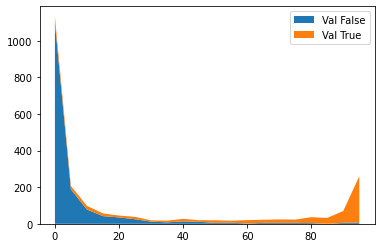

Val False: [1098.  188.   78.   42.   35.   25.   12.    8.   13.   11.    5.    6.
    2.    5.    5.    5.    4.    0.    5.    7.]
Val True: [ 34.  19.  20.  15.  10.  13.   7.   9.  14.   9.  14.  11.  18.  17.
  19.  18.  32.  32.  65. 253.]


In [13]:
#Show Distribution of Prediction Probabilities
#"""
plt.clf()
distribution=[]
ef=np.zeros(20)
et=np.zeros(20)
fpositives=[]
fnegatives=[]
temp_blobs=[]

for x in tqdm(range(len(val_dset))):
    img=val_dset[x][0]
    img_variable = Variable(img.unsqueeze(0).float())
    logit = net(img_variable).detach().numpy()[0]
    valuation=val_dset[x][1].detach().numpy()
    ix=math.floor(logit/.05)
    if ix >= 20:
        ix = 19
    if valuation:
        et[ix]+=1
    else:
        ef[ix]+=1
    
    if np.logical_xor(logit>=.9,valuation==1.0):
        if logit>=.9:
            fpositives.append([img,logit,valuation,x])
        else:
            fnegatives.append([img,logit,valuation,x])
            
temp_blobs=features_blobs
stack=np.vstack([ef,et])
fig, ax = plt.subplots()
ax.stackplot(np.arange(0,100,5), stack)
plt.legend(['Val False', 'Val True'])
plt.show()
print('Val False:',stack[0])
print('Val True:',stack[1])
#"""

In [14]:
fneg=pd.DataFrame(fnegatives,columns=['img','logit','valuation','x'])
fneg=fneg.sort_values(['logit'],0)

fpos=pd.DataFrame(fpositives,columns=['img','logit','valuation','x'])
fpos=fpos.sort_values(['logit'],0)

fnsamples=fneg.head(min([len(fneg),10]))
fntailsamples=None

fpsamples=fpos.head(min([len(fpos),10]))
fptailsamples=None

if len(fneg)>10:
    fntailsamples=fneg.tail(min([10,len(fneg)-10]))

if len(fpos)>10:
    fptailsamples=fpos.tail(min([10,len(fpos)-10]))
print('False Negativse:',len(fnegatives))
print('False Positives:',len(fpositives))

False Negativse: 311
False Positives: 12


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_values except for the argument 'by' will be keyword-only
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_values except for the argument 'by' will be keyword-only
  """


In [15]:
%matplotlib widget
title=['Lowest Prob False Positives','Highest Prob False Positives','Lowest Prob False Negatives','Highest Prob False Negatives']
for y,section in enumerate([fpsamples,fptailsamples,fnsamples,fntailsamples]):
    if section is not None and len(section)>0:
        lfig= plt.figure(title[y])
        subfigs = lfig.subfigures(3,4)
        for x,idx in enumerate(section.index):
            sample=section.loc[idx].values.flatten()

            CAMs,labeled,nr_objects,centers = returnCAM(temp_blobs[sample[3]], weight_softmax, [0])
            oCAMs,olabeled,onr_objects,ocenters = returnOriginalCAM(temp_blobs[sample[3]],weight_softmax,[0])
            subplot=subfigs[math.floor(x/4)][x%4].subplots(2,2)
            subfigs[math.floor(x/4)][x%4].suptitle('Pred:'+str(sample[1])+' Label:'+str(sample[2]))
            subplot[0,0].imshow(oCAMs[-1])
            subplot[0,0].axis('off')
            subplot[0,1].imshow(CAMs[-1])
            subplot[0,1].axis('off')    
            subplot[1,0].imshow(np.transpose(labeled[-1],(1,2,0)))
            subplot[1,0].axis('off')
            subplot[1,1].imshow(np.transpose(sample[0].int(),(1,2,0)))
            subplot[1,1].axis('off')


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …